config


In [1]:
import os

# Đường dẫn đến thư mục muốn tạo
folder_path = '/kaggle/working/saved_images'

# Tạo thư mục nếu nó chưa tồn tại
os.makedirs(folder_path, exist_ok=True)


In [2]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/kaggle/input/horse2zebra-dataset"
VAL_DIR = "/kaggle/input/horse2zebra-dataset"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0
LAMBDA_CYCLE = 10
NUM_WORKERS = 8
NUM_EPOCHS = 25
LOAD_MODEL = False
SAVE_MODEL = True
CHECKPOINT_GEN_H = "genh.pth.tar"
CHECKPOINT_GEN_Z = "genz.pth.tar"
CHECKPOINT_CRITIC_H = "critich.pth.tar"
CHECKPOINT_CRITIC_Z = "criticz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


dataset

In [3]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = np.array(Image.open(zebra_path).convert("RGB"))
        horse_img = np.array(Image.open(horse_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = augmentations["image"]
            horse_img = augmentations["image0"]

        return zebra_img, horse_img


generator 

In [4]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features, num_features * 2, kernel_size=3, stride=2, padding=1
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))


Discriminator

In [5]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                4,
                stride,
                1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


save

In [6]:
import random, torch, os, numpy as np
import torch.nn as nn

import copy

def save_checkpoint(model, optimizer, filename="/kaggle/working/my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

train_fn

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 1334/1334 [08:36<00:00,  2.58it/s, H_fake=0.451, H_real=0.544]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:36<00:00,  2.58it/s, H_fake=0.435, H_real=0.558]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.427, H_real=0.565]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.426, H_real=0.568]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.422, H_real=0.572]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.418, H_real=0.575]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.412, H_real=0.583]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.408, H_real=0.586]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.402, H_real=0.59]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.4, H_real=0.593]


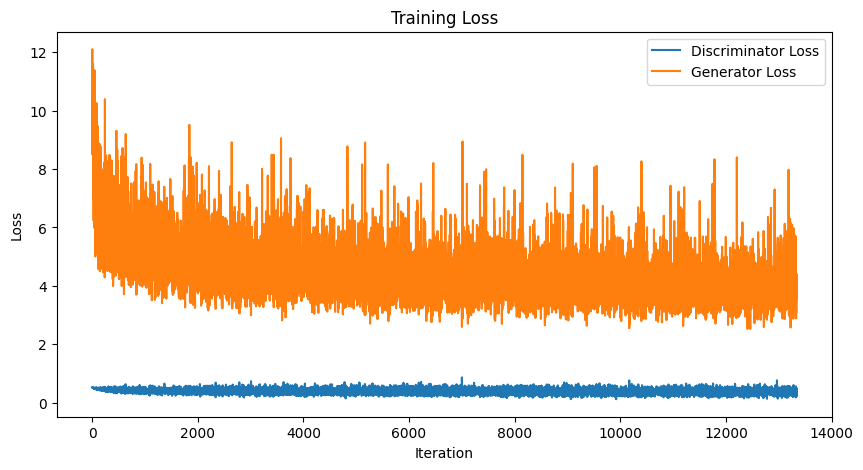

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:34<00:00,  2.59it/s, H_fake=0.397, H_real=0.595]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:34<00:00,  2.59it/s, H_fake=0.394, H_real=0.599]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.391, H_real=0.602]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:36<00:00,  2.58it/s, H_fake=0.389, H_real=0.604]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:34<00:00,  2.59it/s, H_fake=0.384, H_real=0.607]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.383, H_real=0.611]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:34<00:00,  2.59it/s, H_fake=0.38, H_real=0.614]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.374, H_real=0.617]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.376, H_real=0.619]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.377, H_real=0.618]


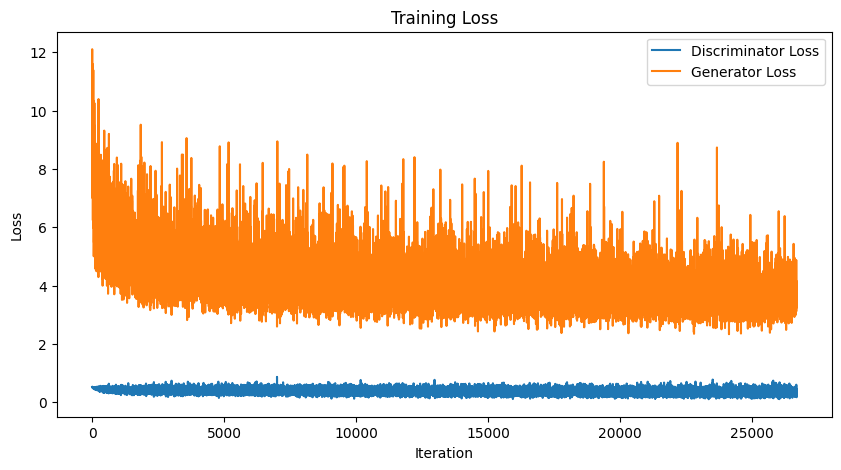

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.375, H_real=0.618]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.374, H_real=0.62]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.374, H_real=0.62]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.373, H_real=0.62]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 1334/1334 [08:35<00:00,  2.59it/s, H_fake=0.377, H_real=0.616]


=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


In [7]:
import torch
import matplotlib.pyplot as plt
import sys
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, loss_history
):
    H_reals = 0
    H_fakes = 0

    loop = tqdm(loader, leave=True)

    for idx, (zebra, horse) in enumerate(loop):
        zebra = zebra.to(DEVICE)
        horse = horse.to(DEVICE)

        # Train Discriminators H and Z
        with torch.cuda.amp.autocast():
            fake_horse = gen_H(zebra)
            D_H_real = disc_H(horse)
            D_H_fake = disc_H(fake_horse.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            fake_zebra = gen_Z(horse)
            D_Z_real = disc_Z(zebra)
            D_Z_fake = disc_Z(fake_zebra.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            # put it together
            D_loss = (D_H_loss + D_Z_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            D_H_fake = disc_H(fake_horse)
            D_Z_fake = disc_Z(fake_zebra)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle loss
            cycle_zebra = gen_Z(fake_horse)
            cycle_horse = gen_H(fake_zebra)
            cycle_zebra_loss = l1(zebra, cycle_zebra)
            cycle_horse_loss = l1(horse, cycle_horse)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_zebra = gen_Z(zebra)
            identity_horse = gen_H(horse)
            identity_zebra_loss = l1(zebra, identity_zebra)
            identity_horse_loss = l1(horse, identity_horse)

            # add all together
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_zebra_loss * LAMBDA_CYCLE
                + cycle_horse_loss * LAMBDA_CYCLE
                + identity_horse_loss * LAMBDA_IDENTITY
                + identity_zebra_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        
        if idx % 200 == 0:
            save_image(fake_horse * 0.5 + 0.5, f"saved_images/horse_{idx}.png")
            save_image(fake_zebra * 0.5 + 0.5, f"saved_images/zebra_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1))
        
        # Ghi lại loss
        loss_history['D'].append(D_loss.item())
        loss_history['G'].append(G_loss.item())

def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history['D'], label='Discriminator Loss')
    plt.plot(loss_history['G'], label='Generator Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.show()


def main():
    # Danh sách để lưu loss
    loss_history = {'G': [], 'D': []}
    disc_H = Discriminator(in_channels=3).to(DEVICE)
    disc_Z = Discriminator(in_channels=3).to(DEVICE)
    gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)
    opt_disc = optim.Adam(
        list(disc_H.parameters()) + list(disc_Z.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    opt_gen = optim.Adam(
        list(gen_Z.parameters()) + list(gen_H.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999),
    )

    L1 = nn.L1Loss()
    mse = nn.MSELoss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN_H,
            gen_H,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_GEN_Z,
            gen_Z,
            opt_gen,
            LEARNING_RATE,
        )
        load_checkpoint(
             CHECKPOINT_CRITIC_H,
            disc_H,
            opt_disc,
            LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC_Z,
            disc_Z,
            opt_disc,
            LEARNING_RATE,
        )

    dataset = HorseZebraDataset(
        root_horse=TRAIN_DIR + "/trainA",
        root_zebra=TRAIN_DIR + "/trainB",
        transform=transforms,
    )
    val_dataset = HorseZebraDataset(
        root_horse="/kaggle/input/horse2zebra-dataset/testA",
        root_zebra="/kaggle/input/horse2zebra-dataset/testB",
        transform=transforms,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
    )
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc_H,
            disc_Z,
            gen_Z,
            gen_H,
            loader,
            opt_disc,
            opt_gen,
            L1,
            mse,
            d_scaler,
            g_scaler,
            loss_history,
        )

        # Kiểm tra nếu epoch chia hết cho 10
        if (epoch + 1) % 10 == 0:
            # In ra đồ thị loss
            plot_loss(loss_history)

        if SAVE_MODEL:
            save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GEN_H)
            save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GEN_Z)
            save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_CRITIC_H)
            save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_CRITIC_Z)



if __name__ == "__main__":
    main()


save